In [2]:
import numpy as np
import torch
import torch.nn.functional as F

In [3]:
#load the data
dataLR_dict = torch.load("serialized_data/dataLR.pt")
dataHR_dict = torch.load("serialized_data/dataHR.pt")

dataLR = dataLR_dict["data"]
dataHR = dataHR_dict["data"]

/tmp/ipykernel_2114/2217057475.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataLR_dict = torch.load("serialized_data/dataLR.pt")
/tmp/ipykernel_2114/2217057475.py:3:

In [4]:
from data_visualisation import plot_single, get_bilinear_interpolation

In [5]:
interpoled_h = get_bilinear_interpolation(dataLR[0, 300, 0], dataHR[0, 300, 0].shape)
interpoled_q = get_bilinear_interpolation(dataLR[0, 300, 1], dataHR[0, 300, 0].shape)

interpoled_h.shape, interpoled_q.shape

(torch.Size([5, 250]), torch.Size([5, 250]))

In [6]:
from data_visualisation import get_bilinear_interpolation, plot_bilinear_interpolation
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim

def compute_mse(dataLR, dataHR):
    mse_loss = torch.ones((dataLR.shape[0], dataLR.shape[1], dataLR.shape[2])) #shape (S, T, 2)
    
    for S in range(dataLR.shape[0]): #loop over simulations
        for T in range(dataLR.shape[1]): 
            interpoled_h = get_bilinear_interpolation(dataLR[S, T, 0], dataHR[S, 0, 0].shape)
            interpoled_q = get_bilinear_interpolation(dataLR[S, T, 1], dataHR[S, 0, 0].shape)
            
            mse_loss_h = F.mse_loss(interpoled_h, dataHR[S, T, 0])
            mse_loss_q = F.mse_loss(interpoled_q, dataHR[S, T, 1])

            mse_loss[S, T, 0] = mse_loss_h
            mse_loss[S, T, 1] = mse_loss_q

    return mse_loss

def compute_SSIM(dataLR, dataHR):
    ssim_loss = torch.ones((dataLR.shape[0], dataLR.shape[1], dataLR.shape[2])) #shape (S, T, 2)
    
    for S in range(dataLR.shape[0]): #loop over simulations
        for T in range(dataLR.shape[1]): 
            interpoled_h = get_bilinear_interpolation(dataLR[S, T, 0], dataHR[S, 0, 0].shape)
            interpoled_q = get_bilinear_interpolation(dataLR[S, T, 1], dataHR[S, 0, 0].shape)
            
            # Convert tensors to numpy arrays
            interpoled_h_np = interpoled_h.cpu().numpy()
            interpoled_q_np = interpoled_q.cpu().numpy()
            dataHR_h_np = dataHR[S, T, 0].cpu().numpy()
            dataHR_q_np = dataHR[S, T, 1].cpu().numpy()
            
            # Specify the data range
            data_range_h = dataHR_h_np.max() - dataHR_h_np.min()
            data_range_q = dataHR_q_np.max() - dataHR_q_np.min()
            
            ssim_loss_h = ssim(interpoled_h_np, dataHR_h_np, win_size=3, data_range=data_range_h)
            ssim_loss_q = ssim(interpoled_q_np, dataHR_q_np, win_size=3, data_range=data_range_q)

            ssim_loss[S, T, 0] = ssim_loss_h
            ssim_loss[S, T, 1] = ssim_loss_q

    return ssim_loss

In [7]:
mse = compute_mse(dataLR[:, 200:], dataHR[:, 200:])
ssim_test = compute_SSIM(dataLR[:, 200:], dataHR[:, 200:])

# ssim_test = compute_SSIM(dataHR[:, 200:], dataHR[:, 200:])

In [8]:
# Find the minimum value and its index
min_mse_val = mse.min()
min_mse_idx = torch.nonzero(mse == min_mse_val, as_tuple=True)

min_ssim_val = ssim_test.min()
min_ssim_idx = torch.nonzero(ssim_test == min_ssim_val, as_tuple=True)

# Find the maximum value and its index
max_mse_val = mse.max()
max_mse_idx = torch.nonzero(mse == max_mse_val, as_tuple=True)

max_ssim_val = ssim_test.max()
max_ssim_idx = torch.nonzero(ssim_test == max_ssim_val, as_tuple=True)

mean_mse = mse.mean()
mean_ssim = ssim_test.mean()

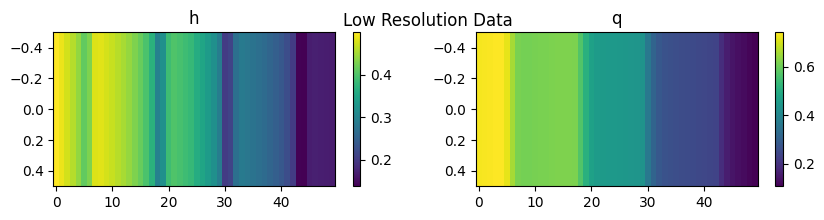

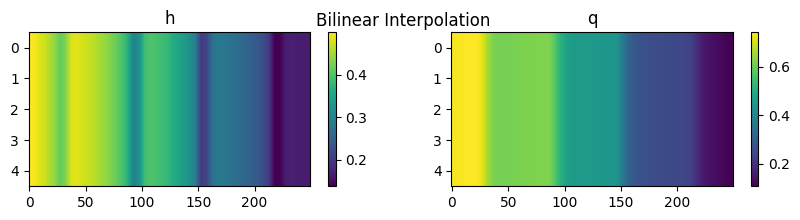

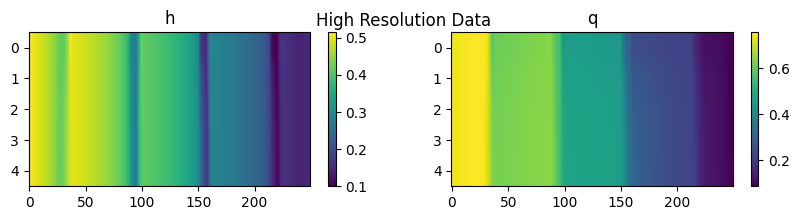

Minimum MSE value: 3.793706127908081e-05 at index (tensor([3]), tensor([329]), tensor([0]))
Maximum MSE value: 1.5011156909167767e-02 at index (tensor([13]), tensor([392]), tensor([1]))
Mean MSE value: 8.135940879583359e-04
Minimum SSIM value: 3.6691904067993164e-01 at index (tensor([13]), tensor([400]), tensor([1]))
Maximum SSIM value: 9.827815890312195e-01 at index (tensor([6]), tensor([328]), tensor([0]))
Mean SSIM value: 8.832863569259644e-01


In [9]:
plot_single(dataLR[3, 329], title="Low Resolution Data")
plot_bilinear_interpolation(dataLR[3, 329], dataHR[3, 329, 0].shape)
plot_single(dataHR[3, 329], title="High Resolution Data")

print(f"Minimum MSE value: {np.format_float_scientific(min_mse_val.item())} at index {min_mse_idx}")
print(f"Maximum MSE value: {np.format_float_scientific(max_mse_val.item())} at index {max_mse_idx}")
print(f"Mean MSE value: {np.format_float_scientific(mean_mse.item())}")

print(f"Minimum SSIM value: {np.format_float_scientific(min_ssim_val.item())} at index {min_ssim_idx}")
print(f"Maximum SSIM value: {np.format_float_scientific(max_ssim_val.item())} at index {max_ssim_idx}")
print(f"Mean SSIM value: {np.format_float_scientific(mean_ssim.item())}")


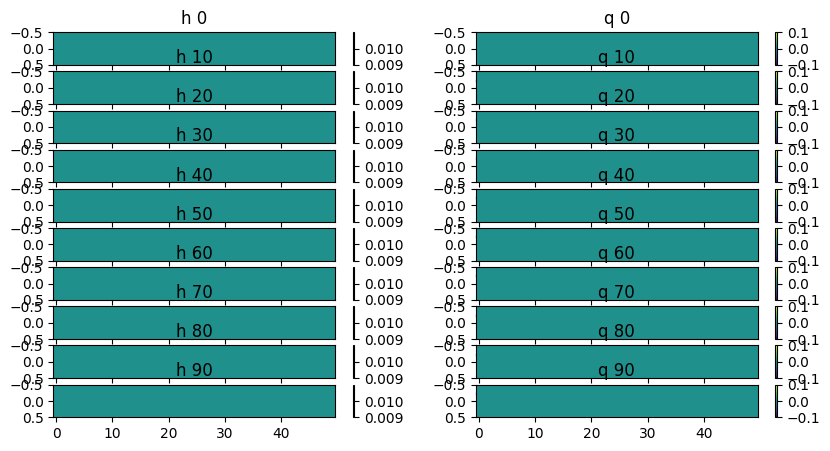

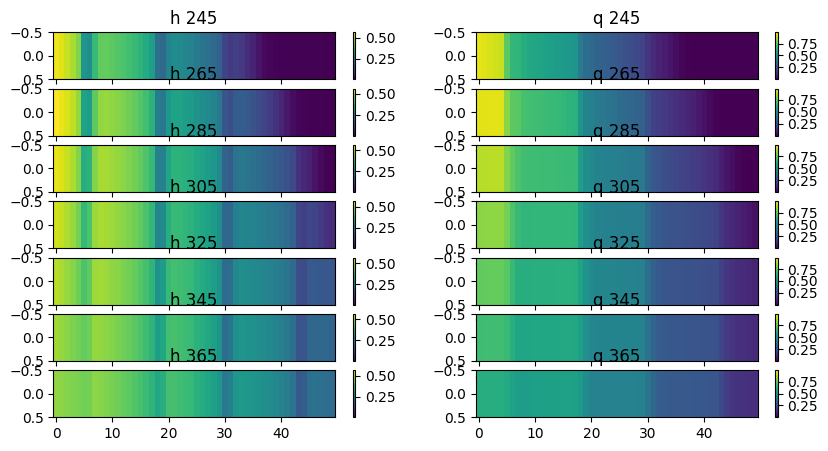

In [10]:
from data_visualisation import plot_batch

plot_batch(dataLR[3], 0, 100, 10)
plot_batch(dataLR[3], 245, 400, 20)


In [11]:
import torch
from data_visualisation import plot_single, plot_bilinear_interpolation

/tmp/ipykernel_6121/1992929646.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataLR_normalized_dict = torch.load("serialized_data/dataLR_normalized.pt")
/tmp/ipykernel

torch.Size([501, 2, 5, 250]) torch.Size([501, 2, 5, 250])
torch.Size([15, 501, 2, 5, 250]) torch.Size([15, 501, 2, 5, 250])


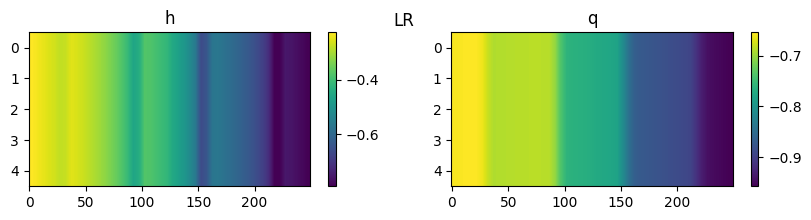

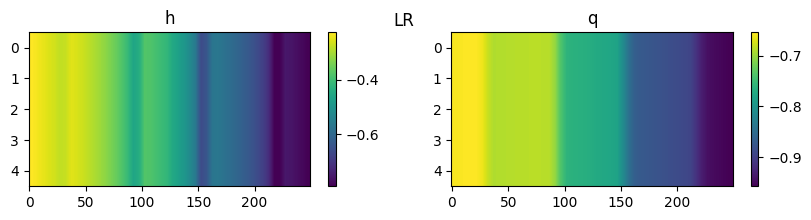

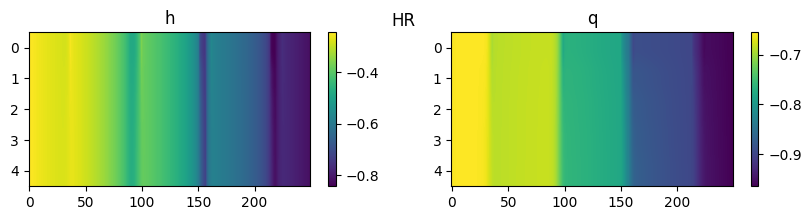

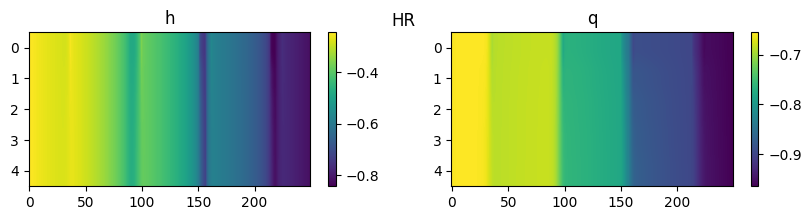

In [54]:
#load the data
dataLR_normalized_dict = torch.load("serialized_data/dataLR_normalized.pt")
dataHR_normalized_dict = torch.load("serialized_data/dataHR_normalized.pt")

dataLR_normalized_stacked_dict = torch.load("serialized_data/dataLR_normalized_stacked.pt")
dataHR_normalized_stacked_dict = torch.load("serialized_data/dataHR_normalized_stacked.pt")

dataLR_normalized = dataLR_normalized_dict["data"]
dataHR_normalized = dataHR_normalized_dict["data"]

dataLR_normalized_stacked = dataLR_normalized_stacked_dict["data"]
dataHR_normalized_stacked = dataHR_normalized_stacked_dict["data"]

print(dataLR_normalized.shape, dataHR_normalized.shape)
print(dataLR_normalized_stacked.shape, dataHR_normalized_stacked.shape)

#plot the data
plot_single(dataLR_normalized[329], title="LR")
plot_single(dataLR_normalized_stacked[0, 329], title="LR")

plot_single(dataHR_normalized[329], title="HR")
plot_single(dataHR_normalized_stacked[0, 329], title="HR")

In [47]:
torch.min(dataLR_normalized), torch.max(dataLR_normalized), torch.min(dataHR_normalized), torch.max(dataHR_normalized)

(tensor(-1.), tensor(-0.1981), tensor(-1.), tensor(-0.2191))

In [42]:
dataLR_normalized.shape, dataHR_normalized.shape

(torch.Size([14, 601, 2, 1, 50]), torch.Size([14, 601, 2, 5, 250]))

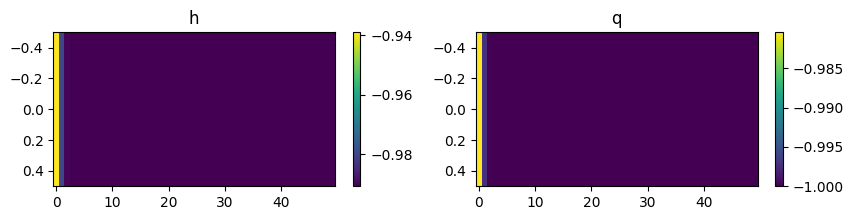

In [19]:
plot_single(dataLR_normalized[13,105])

In [1]:
import torch

In [2]:
lr_tensor = torch.load('/home/maxime/DL-ML/downscalling/experimentations/serialized_data/dataLR.pt')["data"]
hr_tensor = torch.load('/home/maxime/DL-ML/downscalling/experimentations/serialized_data/dataHR.pt')["data"]

/tmp/ipykernel_183642/3452334640.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lr_tensor = torch.load('/home/maxime/DL-ML/downscalling/experimentations/serialized_data

In [3]:
from convlstm.data.transforms import BilinearInterpolation
from convlstm.data.datasets import ConvLSTMDataset

#load the data
dataset = ConvLSTMDataset(lr_tensor, hr_tensor, transform=BilinearInterpolation())

In [4]:
lr_norm, hr_norm = dataset[0]

torch.Size([501, 2, 1, 50]) torch.Size([501, 2, 5, 250])
NEW SHAPES torch.Size([501, 2, 5, 250]) torch.Size([501, 2, 5, 250])


In [5]:
lr_norm.shape, hr_norm.shape, torch.min(lr_norm), torch.max(lr_norm), torch.min(hr_norm), torch.max(hr_norm)

(torch.Size([501, 2, 5, 250]),
 torch.Size([501, 2, 5, 250]),
 tensor(-1.),
 tensor(-0.1981),
 tensor(-1.),
 tensor(-0.2191))

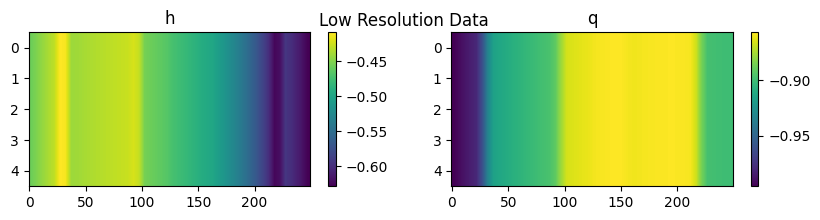

In [7]:
from data_visualisation import plot_single
plot_single(lr_norm[500], title="Low Resolution Data")

In [118]:
predictions = torch.load("serialized_data/prediction_1.pt")["data"]

/tmp/ipykernel_6121/4012937380.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predictions = torch.load("serialized_data/prediction_1.pt")["data"]


In [120]:
predictions.shape

torch.Size([501, 2, 5, 250])

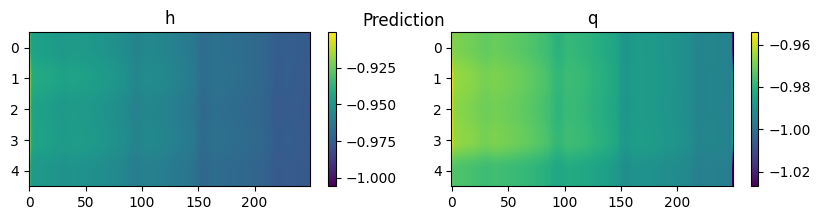

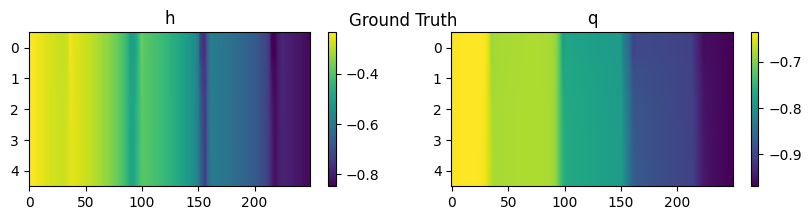

In [121]:
#compare the prediction with the ground truth
plot_single(predictions[320].cpu(), title="Prediction")  # Move tensor to CPU
plot_single(hr_norm[0, 320].cpu(), title="Ground Truth") 

In [129]:
import torch.nn.functional as F
#put the prediction and the ground truth in the same device
predictions = predictions.to(hr_norm.device)

#compute loss
loss = F.mse_loss(predictions[300:350], hr_norm[0, 300:350])
loss

tensor(0.1446)

In [62]:
data = dataset[0]
lr, hr = data

In [67]:
lr.shape, hr.shape

(torch.Size([501, 2, 1, 50]), torch.Size([501, 2, 5, 250]))

In [72]:
#predict
pred = model(lr.unsqueeze(0))
pred.shape

from data_visualisation import plot_single
plot_single(pred[0, 0], title="Prediction")

TypeError: 'collections.OrderedDict' object is not callable